In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [79]:
df_fields = pd.read_csv('../data/fields.csv', delimiter=';', decimal=',', skiprows=[0, 2])
df_value = pd.read_csv('../data/value.csv', delimiter=';', decimal=',', skiprows=[0, 1], parse_dates=['inv_item_date'], date_format={'inv_item_date': '%d.%m.%Y'})
df_works = pd.read_csv('../data/works.csv', delimiter=';', decimal=',', skiprows=[0, 1], parse_dates=['start_date', 'end_date'], date_format={'start_date': '%d.%m.%Y', 'end_date': '%d.%m.%Y'})

df_works['area'] = df_works['area'].str.replace(',', '.').astype(float)

# Формирование таблицы с полями и их yield_plan, yield_fact

In [80]:
valid_work_subtypes = ['Прямое комбайнирование', 'Подбор и обмолот', 'Заготовка сенажа', 'Уборка силос/карнаж', 'Подбор (корм)', 'Вывоз', 'Прессование']
valid_work_types = ['Обработка почвы', 'Уборка']

df_yield_fact_works = df_works.query(
    f"work_type in {valid_work_types} and work_subtype in {valid_work_subtypes}"
)[['season', 'field', 'yield_fact', 'area', 'work_type']]

df_yield_fact = (
    df_yield_fact_works
    .assign(weighted_yield=lambda x: x['yield_fact'] * x['area'])
    .groupby(['field', 'season'])
    .agg(weighted_yield=('weighted_yield', 'sum'), total_area=('area', 'sum'))
    .assign(weighted_mean=lambda x: x['weighted_yield'] / x['total_area'])
    .reset_index()[['field', 'season', 'weighted_mean']]
)

df_yield_fact = df_yield_fact.rename(columns={'weighted_mean': 'yield_fact'})

df_yield_fact.head()

,field,season,yield_fact
0,02.09.02.002.01,2023,1.568170
1,02.09.02.002.01,2024,0.000000
2,02.09.02.015.00,2023,1.223696
3,02.09.02.019.00,2023,2.150000
4,02.09.03.032.00,2023,268.696209


In [81]:
df_fields_tmp = df_fields[['season', 'field', 'p2o5', 'k2o', 'humus', 'ph', 'crop', 'region', 'yield_plan']]

df_yield = df_fields_tmp.merge(df_yield_fact, how='left', on=['field', 'season'])

df_yield = df_yield.dropna()

df_yield.head()

,season,field,p2o5,k2o,humus,ph,crop,region,yield_plan,yield_fact
0,2023,22.47.01.001.01,221.05,206.3,4.05,5.25,Оз.пшеница мягкая,Алтай,3.8,190.592405
3,2023,22.47.01.003.00,186.50,174.8,5.90,5.40,Оз.пшеница мягкая,Алтай,3.8,1.851617
4,2023,22.47.01.004.00,166.60,147.9,5.60,5.40,Оз.пшеница мягкая,Алтай,3.8,1.418186
7,2023,22.47.01.006.02,194.70,195.9,4.00,5.15,Оз.пшеница мягкая,Алтай,3.8,2.187347
9,2023,22.47.01.007.02,184.20,171.4,4.40,5.05,Оз.пшеница мягкая,Алтай,3.8,2.109071


# Добавление информации о товарно-материальных ценностях

In [82]:
df_value.head()

,field,inv_item_type,inv_item_name,inv_item_weight,inv_item_unit,inv_item_dose,inv_item_date,work_id
0,36.01.21.025.01,Удобрения,Удобрение 31,15017.6,кг,260.0,2024-10-28,E3A7DAEB-D124-4685-ADE1-199818C77361
1,36.14.12.064.00,Удобрения,Удобрение 31,6500.0,м3,65.0,2024-10-28,0AB8C8D7-04BD-4483-98B2-3E062CDD7E3E
2,36.14.16.008.00,Удобрения,Удобрение 49,7865.0,т,65.0,2024-10-28,00E51F81-0A4F-4983-B068-877A089FFD33
3,36.14.16.008.00,Удобрения,Удобрение 49,10985.0,т,65.0,2024-10-28,150F0150-8061-4CE9-9570-B112CBAD7C51
4,36.14.16.008.00,Удобрения,Удобрение 49,10985.0,т,65.0,2024-10-28,D5D1EADB-D159-4CF8-8C2A-171517ACD403


In [83]:
df_value['inv_item_type'].value_counts()

inv_item_type
СЗР          100115
Удобрения     43008
Семена        27690
Name: count, dtype: int64

In [84]:
df_fert = df_value[df_value['inv_item_type'] == 'Удобрения']

In [85]:
df_fert.isnull().sum()

field              0
inv_item_type      0
inv_item_name      0
inv_item_weight    0
inv_item_unit      2
inv_item_dose      0
inv_item_date      0
work_id            0
dtype: int64

In [86]:
df_fert['inv_item_unit'].unique()

array(['кг', 'м3', 'т', 'л', nan, 'шт'], dtype=object)

In [87]:
df_fert.shape

(43008, 8)

## В итоге стоит превести всё к общим размерностям:
кг, м3, п.е., п. ед., упак, шт

In [88]:
df_fert = df_fert.dropna()

In [89]:
df_fert['inv_item_unit'].value_counts()

inv_item_unit
кг    31047
т      7862
л      3097
м3      999
шт        1
Name: count, dtype: int64

In [90]:
df_fert.loc[df_fert['inv_item_unit'] == 'т', 'inv_item_dose'] *= 1000
df_fert.loc[df_fert['inv_item_unit'] == 'т', 'inv_item_unit'] = 'кг'
df_fert.head()

,field,inv_item_type,inv_item_name,inv_item_weight,inv_item_unit,inv_item_dose,inv_item_date,work_id
0,36.01.21.025.01,Удобрения,Удобрение 31,15017.6,кг,260.0,2024-10-28,E3A7DAEB-D124-4685-ADE1-199818C77361
1,36.14.12.064.00,Удобрения,Удобрение 31,6500.0,м3,65.0,2024-10-28,0AB8C8D7-04BD-4483-98B2-3E062CDD7E3E
2,36.14.16.008.00,Удобрения,Удобрение 49,7865.0,кг,65000.0,2024-10-28,00E51F81-0A4F-4983-B068-877A089FFD33
3,36.14.16.008.00,Удобрения,Удобрение 49,10985.0,кг,65000.0,2024-10-28,150F0150-8061-4CE9-9570-B112CBAD7C51
4,36.14.16.008.00,Удобрения,Удобрение 49,10985.0,кг,65000.0,2024-10-28,D5D1EADB-D159-4CF8-8C2A-171517ACD403


In [91]:
df_fert.loc[df_fert['inv_item_unit'] == 'м3', 'inv_item_dose'] *= 1000
df_fert.loc[df_fert['inv_item_unit'] == 'м3', 'inv_item_unit'] = 'л'
df_fert.head()

,field,inv_item_type,inv_item_name,inv_item_weight,inv_item_unit,inv_item_dose,inv_item_date,work_id
0,36.01.21.025.01,Удобрения,Удобрение 31,15017.6,кг,260.0,2024-10-28,E3A7DAEB-D124-4685-ADE1-199818C77361
1,36.14.12.064.00,Удобрения,Удобрение 31,6500.0,л,65000.0,2024-10-28,0AB8C8D7-04BD-4483-98B2-3E062CDD7E3E
2,36.14.16.008.00,Удобрения,Удобрение 49,7865.0,кг,65000.0,2024-10-28,00E51F81-0A4F-4983-B068-877A089FFD33
3,36.14.16.008.00,Удобрения,Удобрение 49,10985.0,кг,65000.0,2024-10-28,150F0150-8061-4CE9-9570-B112CBAD7C51
4,36.14.16.008.00,Удобрения,Удобрение 49,10985.0,кг,65000.0,2024-10-28,D5D1EADB-D159-4CF8-8C2A-171517ACD403


In [92]:
df_fert['inv_item_unit'].value_counts()

inv_item_unit
кг    38909
л      4096
шт        1
Name: count, dtype: int64

In [93]:
r_to_drop = df_fert[df_fert['inv_item_unit'] == 'шт'].index

df_fert = df_fert.drop(r_to_drop)

df_fert['inv_item_unit'].value_counts()

inv_item_unit
кг    38909
л      4096
Name: count, dtype: int64

## Добавление сезона

In [94]:
df_works_tmp = df_works[['season', 'work_id']].sort_values(by='work_id')
df_works_tmp.head(5)

,season,work_id
28762,2023,0000709B-EDB8-4A6F-A2C2-448AD1A70316
31143,2023,0000ACB9-08B0-483E-BAFD-C45570C2DA70
107954,2024,0000BD48-61E4-4F77-8C53-0CC5535655ED
144756,2024,0000D2BE-1620-4C00-88ED-10CA7C60BCCF
19142,2023,0000F83C-937B-49B7-AF69-0A573B099D1B


In [95]:
df_fert = df_fert[['field', 'inv_item_name', 'inv_item_weight', 'inv_item_unit', 'work_id']].sort_values(by='work_id')

df_fert.head(5)

,field,inv_item_name,inv_item_weight,inv_item_unit,work_id
113923,36.14.06.025.00,Удобрение 10,44252.33,кг,0000F83C-937B-49B7-AF69-0A573B099D1B
143945,47.22.06.036.02,Удобрение 31,10296.00,л,00022E46-3B96-4FD2-A9F2-10FC62AF4D5E
127023,54.17.12.038.00,Удобрение 49,2293.20,кг,0002E9E7-7E9F-49D3-B189-B4EBD7011E4E
3667,56.28.06.035.02,Удобрение 57,210085.20,кг,00038C65-2CB9-42C3-B51A-95A2A9081B60
44122,16.13.12.055.00,Удобрение 57,914.06,кг,0003C1B2-B2A1-47E8-A43A-3B738A33CB9B


In [96]:
df_fert = df_fert.merge(df_works_tmp, how='left', on=['work_id']).dropna()
df_fert['season'] = df_fert['season'].astype(int)

df_fert.head()

,field,inv_item_name,inv_item_weight,inv_item_unit,work_id,season
0,36.14.06.025.00,Удобрение 10,44252.33,кг,0000F83C-937B-49B7-AF69-0A573B099D1B,2023
4,16.13.12.055.00,Удобрение 57,914.06,кг,0003C1B2-B2A1-47E8-A43A-3B738A33CB9B,2024
5,54.17.04.019.01,Удобрение 10,673920.00,кг,00050012-77E6-46C5-905A-00DB2DD97297,2024
9,40.10.13.004.00,Удобрение 14,540749.74,кг,000ABF02-B7CF-47BF-A07C-7C0AE76131F4,2024
11,54.17.02.002.02,Удобрение 23,9921.45,л,000CEDAF-47DA-4EF7-BF04-EB6AE99B905A,2023


In [97]:
df_fert = df_fert.drop('work_id', axis=1)
df_fert.head()

,field,inv_item_name,inv_item_weight,inv_item_unit,season
0,36.14.06.025.00,Удобрение 10,44252.33,кг,2023
4,16.13.12.055.00,Удобрение 57,914.06,кг,2024
5,54.17.04.019.01,Удобрение 10,673920.00,кг,2024
9,40.10.13.004.00,Удобрение 14,540749.74,кг,2024
11,54.17.02.002.02,Удобрение 23,9921.45,л,2023


## Умная группировка

In [98]:
df_fert = df_fert.groupby(by=['field', 'season', 'inv_item_name', 'inv_item_unit']).agg({
    'inv_item_weight' : 'sum'
}).reset_index()

df_fert = df_fert.groupby(by=['field', 'season', 'inv_item_unit']).agg({
    'inv_item_weight': 'mean'
}).reset_index().sort_values(by='field')

df_fert.head()

,field,season,inv_item_unit,inv_item_weight
0,02.09.02.002.01,2023,кг,1879808.13
1,02.09.02.002.01,2024,кг,819987.19
2,02.09.02.003.00,2024,кг,1095063.89
3,02.09.02.013.00,2024,кг,81640.47
4,02.09.02.015.00,2023,кг,171677.43


In [99]:
df_fert = df_fert.pivot(index=["field", "season"], columns="inv_item_unit", values="inv_item_weight").reset_index().fillna(value=0)

In [100]:
df_fert.columns.name = None

In [101]:
df_fert.head()

,field,season,кг,л
0,02.09.02.002.01,2023,1879808.13,0.0
1,02.09.02.002.01,2024,819987.19,0.0
2,02.09.02.003.00,2024,1095063.89,0.0
3,02.09.02.013.00,2024,81640.47,0.0
4,02.09.02.015.00,2023,171677.43,0.0


# СЗР + препараты

In [102]:
df_value['inv_item_type'].value_counts()

inv_item_type
СЗР          100115
Удобрения     43008
Семена        27690
Name: count, dtype: int64

In [103]:
df_value.head()

,field,inv_item_type,inv_item_name,inv_item_weight,inv_item_unit,inv_item_dose,inv_item_date,work_id
0,36.01.21.025.01,Удобрения,Удобрение 31,15017.6,кг,260.0,2024-10-28,E3A7DAEB-D124-4685-ADE1-199818C77361
1,36.14.12.064.00,Удобрения,Удобрение 31,6500.0,м3,65.0,2024-10-28,0AB8C8D7-04BD-4483-98B2-3E062CDD7E3E
2,36.14.16.008.00,Удобрения,Удобрение 49,7865.0,т,65.0,2024-10-28,00E51F81-0A4F-4983-B068-877A089FFD33
3,36.14.16.008.00,Удобрения,Удобрение 49,10985.0,т,65.0,2024-10-28,150F0150-8061-4CE9-9570-B112CBAD7C51
4,36.14.16.008.00,Удобрения,Удобрение 49,10985.0,т,65.0,2024-10-28,D5D1EADB-D159-4CF8-8C2A-171517ACD403


In [104]:
df_plant_protect = df_value[df_value['inv_item_type'] == "СЗР"][['field', 'inv_item_name', 'inv_item_weight', 'inv_item_unit', 'work_id']]

df_plant_protect.head()

,field,inv_item_name,inv_item_weight,inv_item_unit,work_id
291,02.09.06.074.00,Препарат 23,39.10,л,27A8B4B1-C74B-457C-8EE5-116B1CA95A0F
292,02.09.06.074.00,Препарат 487,109.49,л,27A8B4B1-C74B-457C-8EE5-116B1CA95A0F
293,02.09.06.074.00,Препарат 376,195.52,л,27A8B4B1-C74B-457C-8EE5-116B1CA95A0F
294,02.09.06.075.00,Препарат 23,116.90,л,EE985EF3-7F94-47D4-85D9-8659BA79CCAF
295,02.09.06.075.00,Препарат 376,584.48,л,EE985EF3-7F94-47D4-85D9-8659BA79CCAF


In [105]:
df_works_tmp.head()

,season,work_id
28762,2023,0000709B-EDB8-4A6F-A2C2-448AD1A70316
31143,2023,0000ACB9-08B0-483E-BAFD-C45570C2DA70
107954,2024,0000BD48-61E4-4F77-8C53-0CC5535655ED
144756,2024,0000D2BE-1620-4C00-88ED-10CA7C60BCCF
19142,2023,0000F83C-937B-49B7-AF69-0A573B099D1B


In [106]:
df_plant_protect = df_plant_protect.merge(df_works_tmp, how='left', on=['work_id']).dropna()
df_plant_protect['season'] = df_plant_protect['season'].astype(int)

df_plant_protect.head()

,field,inv_item_name,inv_item_weight,inv_item_unit,work_id,season
0,02.09.06.074.00,Препарат 23,39.10,л,27A8B4B1-C74B-457C-8EE5-116B1CA95A0F,2024
1,02.09.06.074.00,Препарат 487,109.49,л,27A8B4B1-C74B-457C-8EE5-116B1CA95A0F,2024
2,02.09.06.074.00,Препарат 376,195.52,л,27A8B4B1-C74B-457C-8EE5-116B1CA95A0F,2024
3,02.09.06.075.00,Препарат 23,116.90,л,EE985EF3-7F94-47D4-85D9-8659BA79CCAF,2024
4,02.09.06.075.00,Препарат 376,584.48,л,EE985EF3-7F94-47D4-85D9-8659BA79CCAF,2024


In [107]:
df_plant_protect = df_plant_protect.drop('work_id', axis=1)

In [108]:
df_plant_protect.head()

,field,inv_item_name,inv_item_weight,inv_item_unit,season
0,02.09.06.074.00,Препарат 23,39.10,л,2024
1,02.09.06.074.00,Препарат 487,109.49,л,2024
2,02.09.06.074.00,Препарат 376,195.52,л,2024
3,02.09.06.075.00,Препарат 23,116.90,л,2024
4,02.09.06.075.00,Препарат 376,584.48,л,2024


In [109]:
df_plant_protect['inv_item_unit'].value_counts()

inv_item_unit
л       58460
кг       9335
упак        5
Name: count, dtype: int64

In [110]:
r_to_drop = df_plant_protect[df_plant_protect['inv_item_unit'] == 'упак'].index

df_plant_protect = df_plant_protect.drop(r_to_drop)

df_plant_protect['inv_item_unit'].value_counts()

inv_item_unit
л     58460
кг     9335
Name: count, dtype: int64

In [111]:
df_plant_protect.head()

,field,inv_item_name,inv_item_weight,inv_item_unit,season
0,02.09.06.074.00,Препарат 23,39.10,л,2024
1,02.09.06.074.00,Препарат 487,109.49,л,2024
2,02.09.06.074.00,Препарат 376,195.52,л,2024
3,02.09.06.075.00,Препарат 23,116.90,л,2024
4,02.09.06.075.00,Препарат 376,584.48,л,2024


In [112]:
df_plant_protect = df_plant_protect.groupby(by=['field', 'season', 'inv_item_name', 'inv_item_unit']).agg({
    'inv_item_weight' : 'sum'
}).reset_index()

df_plant_protect = df_plant_protect.groupby(by=['field', 'season', 'inv_item_unit']).agg({
    'inv_item_weight': 'mean'
}).reset_index().sort_values(by='field')

df_plant_protect.head()

,field,season,inv_item_unit,inv_item_weight
0,02.09.02.002.01,2023,кг,6.250
1,02.09.02.002.01,2023,л,157.892
2,02.09.02.002.01,2024,кг,7.810
3,02.09.02.002.01,2024,л,198.535
4,02.09.02.003.00,2024,кг,4.290


In [113]:
df_plant_protect = df_plant_protect.pivot(index=["field", "season"], columns="inv_item_unit", values="inv_item_weight").reset_index().fillna(value=0)

In [114]:
df_plant_protect.columns.name = None

In [115]:
df_plant_protect.head()

,field,season,кг,л
0,02.09.02.002.01,2023,6.25,157.892000
1,02.09.02.002.01,2024,7.81,198.535000
2,02.09.02.003.00,2024,4.29,88.293333
3,02.09.02.013.00,2024,1.17,24.110000
4,02.09.02.015.00,2023,1.89,47.716000


# Формирование основной таблицы

In [116]:
df_yield.head()

,season,field,p2o5,k2o,humus,ph,crop,region,yield_plan,yield_fact
0,2023,22.47.01.001.01,221.05,206.3,4.05,5.25,Оз.пшеница мягкая,Алтай,3.8,190.592405
3,2023,22.47.01.003.00,186.50,174.8,5.90,5.40,Оз.пшеница мягкая,Алтай,3.8,1.851617
4,2023,22.47.01.004.00,166.60,147.9,5.60,5.40,Оз.пшеница мягкая,Алтай,3.8,1.418186
7,2023,22.47.01.006.02,194.70,195.9,4.00,5.15,Оз.пшеница мягкая,Алтай,3.8,2.187347
9,2023,22.47.01.007.02,184.20,171.4,4.40,5.05,Оз.пшеница мягкая,Алтай,3.8,2.109071


In [117]:
df_fert.head()

,field,season,кг,л
0,02.09.02.002.01,2023,1879808.13,0.0
1,02.09.02.002.01,2024,819987.19,0.0
2,02.09.02.003.00,2024,1095063.89,0.0
3,02.09.02.013.00,2024,81640.47,0.0
4,02.09.02.015.00,2023,171677.43,0.0


In [118]:
df_plant_protect.head()

,field,season,кг,л
0,02.09.02.002.01,2023,6.25,157.892000
1,02.09.02.002.01,2024,7.81,198.535000
2,02.09.02.003.00,2024,4.29,88.293333
3,02.09.02.013.00,2024,1.17,24.110000
4,02.09.02.015.00,2023,1.89,47.716000


In [119]:
df_main = df_yield.merge(df_fert, how='left', on=['field', 'season']).merge(df_plant_protect, how='left', on=['field', 'season'], suffixes=('_fert', '_pp'))

In [120]:
df_main.head()

,season,field,p2o5,k2o,humus,ph,crop,region,yield_plan,yield_fact,кг_fert,л_fert,кг_pp,л_pp
0,2023,22.47.01.001.01,221.05,206.3,4.05,5.25,Оз.пшеница мягкая,Алтай,3.8,190.592405,4457166.035,0.0,13.94,127.390
1,2023,22.47.01.003.00,186.50,174.8,5.90,5.40,Оз.пшеница мягкая,Алтай,3.8,1.851617,8226128.065,0.0,20.58,182.256
2,2023,22.47.01.004.00,166.60,147.9,5.60,5.40,Оз.пшеница мягкая,Алтай,3.8,1.418186,4386226.595,0.0,12.27,108.668
3,2023,22.47.01.006.02,194.70,195.9,4.00,5.15,Оз.пшеница мягкая,Алтай,3.8,2.187347,586686.335,0.0,2.89,26.346
4,2023,22.47.01.007.02,184.20,171.4,4.40,5.05,Оз.пшеница мягкая,Алтай,3.8,2.109071,1013707.990,0.0,3.89,35.592


In [121]:
df_main.isna().sum()

season           0
field            0
p2o5             0
k2o              0
humus            0
ph               0
crop             0
region           0
yield_plan       0
yield_fact       0
кг_fert       2337
л_fert        2337
кг_pp         1759
л_pp          1759
dtype: int64

In [122]:
df_main = df_main.fillna(value=0)

In [123]:
df_main['fact_plan_diff'] = df_main['yield_fact'] - df_main['yield_plan']

In [124]:
df_main.head()

,season,field,p2o5,k2o,humus,ph,crop,region,yield_plan,yield_fact,кг_fert,л_fert,кг_pp,л_pp,fact_plan_diff
0,2023,22.47.01.001.01,221.05,206.3,4.05,5.25,Оз.пшеница мягкая,Алтай,3.8,190.592405,4457166.035,0.0,13.94,127.390,186.792405
1,2023,22.47.01.003.00,186.50,174.8,5.90,5.40,Оз.пшеница мягкая,Алтай,3.8,1.851617,8226128.065,0.0,20.58,182.256,-1.948383
2,2023,22.47.01.004.00,166.60,147.9,5.60,5.40,Оз.пшеница мягкая,Алтай,3.8,1.418186,4386226.595,0.0,12.27,108.668,-2.381814
3,2023,22.47.01.006.02,194.70,195.9,4.00,5.15,Оз.пшеница мягкая,Алтай,3.8,2.187347,586686.335,0.0,2.89,26.346,-1.612653
4,2023,22.47.01.007.02,184.20,171.4,4.40,5.05,Оз.пшеница мягкая,Алтай,3.8,2.109071,1013707.990,0.0,3.89,35.592,-1.690929


In [125]:
df_main.to_csv('../data/df_main.csv')

# Распределение и чистка

In [126]:
df_main.head()

,season,field,p2o5,k2o,humus,ph,crop,region,yield_plan,yield_fact,кг_fert,л_fert,кг_pp,л_pp,fact_plan_diff
0,2023,22.47.01.001.01,221.05,206.3,4.05,5.25,Оз.пшеница мягкая,Алтай,3.8,190.592405,4457166.035,0.0,13.94,127.390,186.792405
1,2023,22.47.01.003.00,186.50,174.8,5.90,5.40,Оз.пшеница мягкая,Алтай,3.8,1.851617,8226128.065,0.0,20.58,182.256,-1.948383
2,2023,22.47.01.004.00,166.60,147.9,5.60,5.40,Оз.пшеница мягкая,Алтай,3.8,1.418186,4386226.595,0.0,12.27,108.668,-2.381814
3,2023,22.47.01.006.02,194.70,195.9,4.00,5.15,Оз.пшеница мягкая,Алтай,3.8,2.187347,586686.335,0.0,2.89,26.346,-1.612653
4,2023,22.47.01.007.02,184.20,171.4,4.40,5.05,Оз.пшеница мягкая,Алтай,3.8,2.109071,1013707.990,0.0,3.89,35.592,-1.690929


In [127]:
df_main.shape

(7324, 15)

## До чистки

### Хим

array([[<Axes: title={'center': 'p2o5'}>,
        <Axes: title={'center': 'k2o'}>],
       [<Axes: title={'center': 'humus'}>,
        <Axes: title={'center': 'ph'}>]], dtype=object)

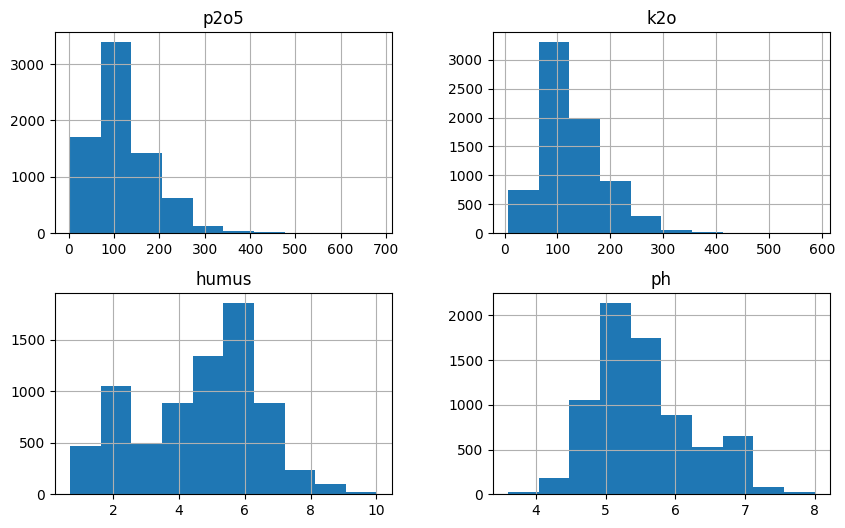

In [128]:
df_main[['p2o5', 'k2o', 'humus', 'ph']].hist(figsize=(10, 6))

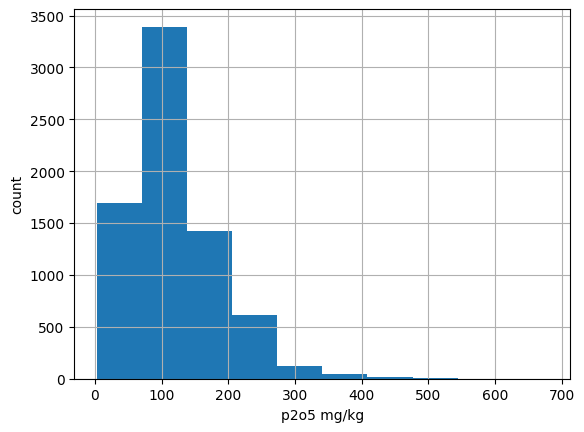

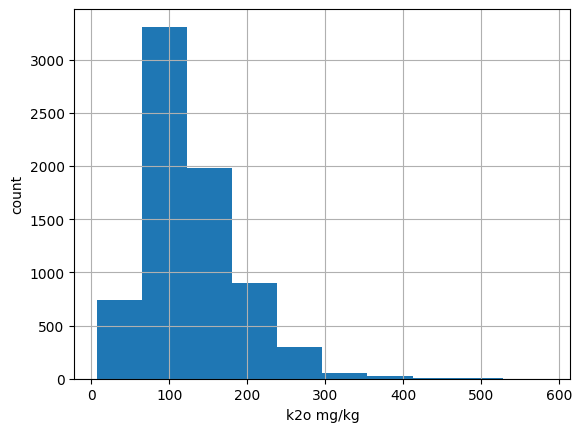

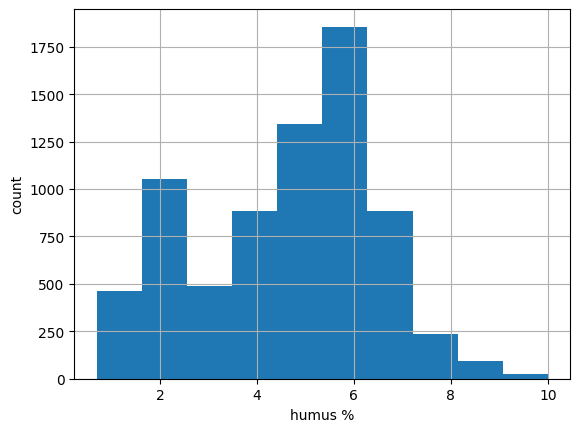

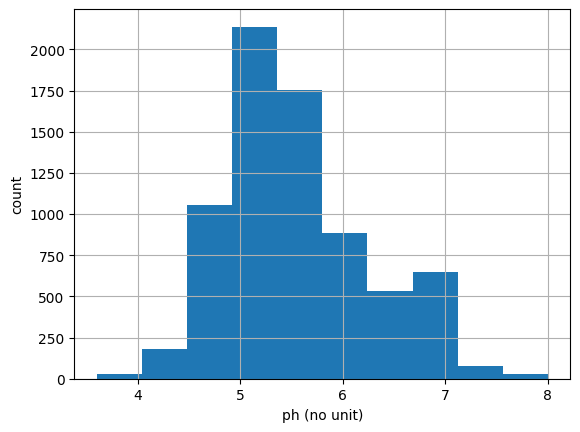

In [129]:
# p2o5
df_main['p2o5'].hist()

plt.xlabel('p2o5 mg/kg')
plt.ylabel('count')

plt.show()

# k2o
df_main['k2o'].hist()

plt.xlabel('k2o mg/kg')
plt.ylabel('count')

plt.show()

# humus
df_main['humus'].hist()

plt.xlabel('humus %')
plt.ylabel('count')

plt.show()

# ph
df_main['ph'].hist()

plt.xlabel('ph (no unit)')
plt.ylabel('count')

plt.show()


### Категориальные признаки

In [130]:
top_crops = df_main['crop'].value_counts().head(10).index.to_list()

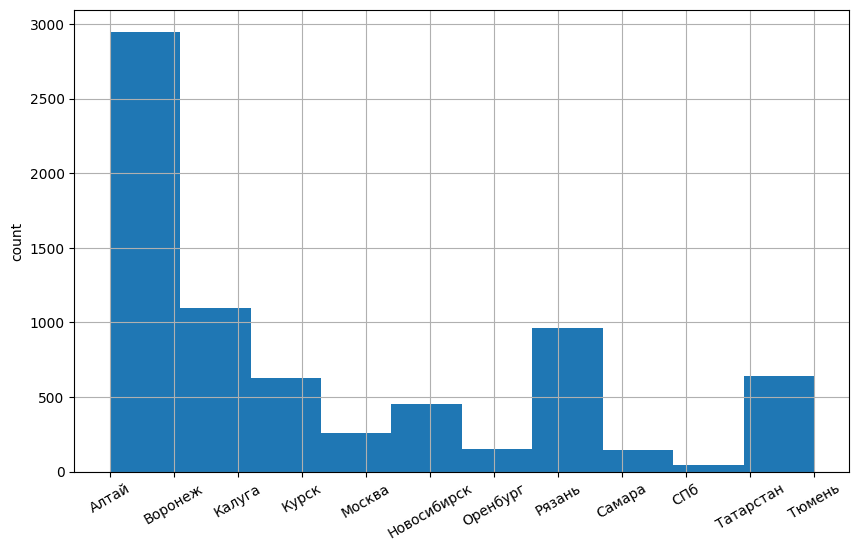

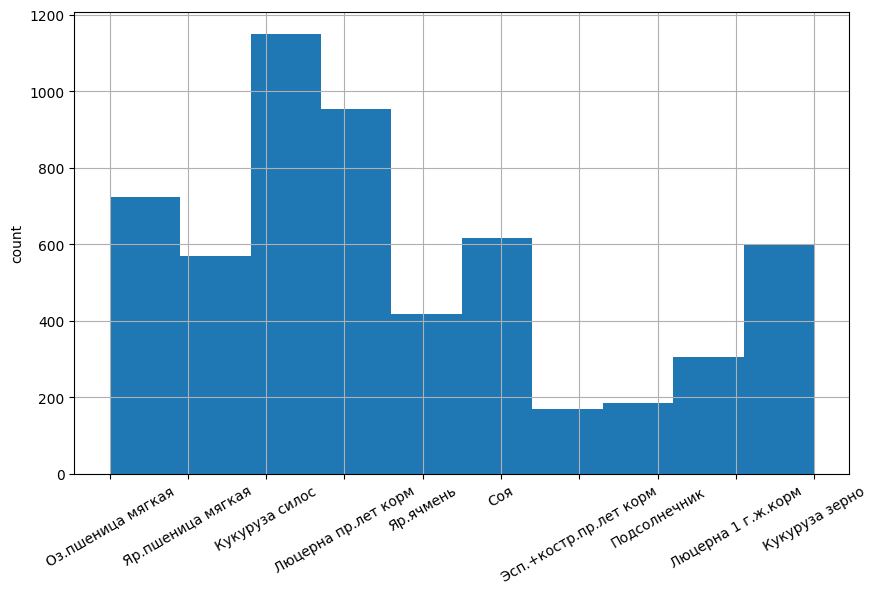

In [131]:
df_main['region'].hist(figsize=(10, 6), xrot=30)

plt.ylabel('count')

plt.show()

df_main.query(f"crop in {top_crops}")['crop'].hist(figsize=(10, 6), xrot=30)

plt.ylabel('count')

plt.show()

### Урожайности

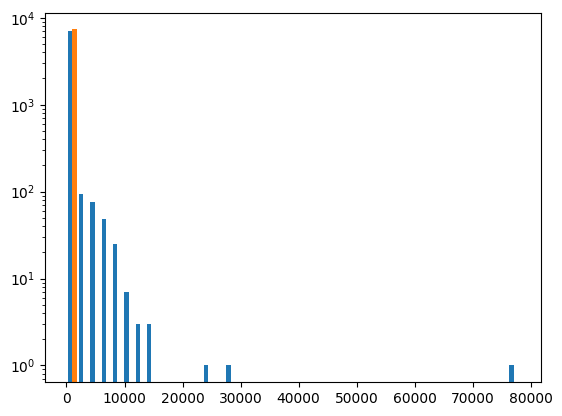

In [132]:
plt.hist([df_main['yield_fact'], df_main['yield_plan']], bins=40)

plt.yscale('log')

plt.show()

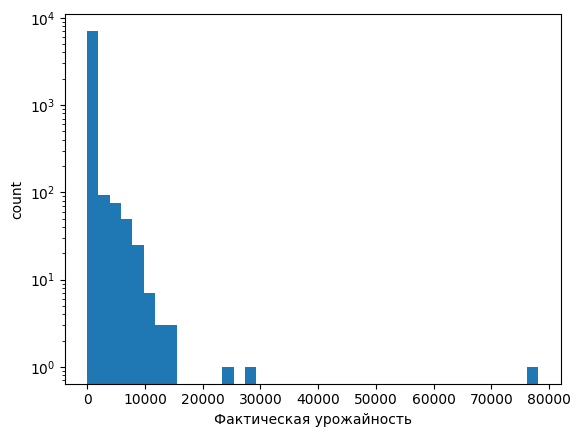

In [133]:
plt.hist(df_main['yield_fact'], bins=40)

plt.yscale('log')

plt.xlabel('Фактическая урожайность')
plt.ylabel('count')

plt.show()

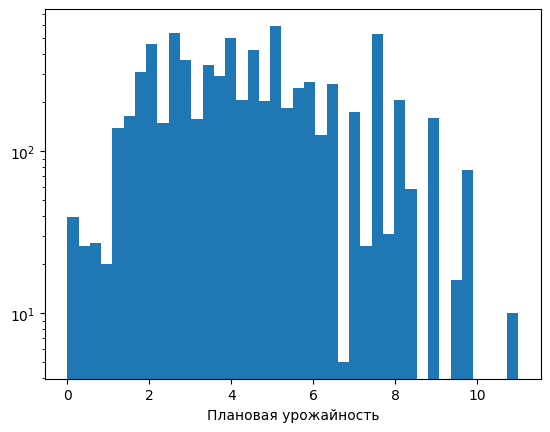

In [134]:
plt.hist(df_main['yield_plan'], bins=40)

plt.yscale('log')

plt.xlabel('Плановая урожайность')

plt.show()

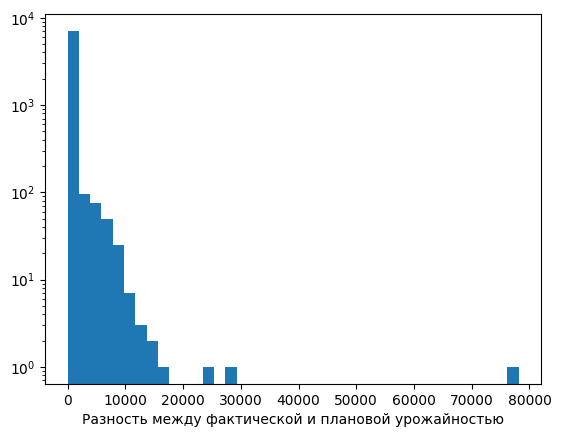

In [135]:
plt.hist(df_main['fact_plan_diff'], bins=40)

plt.yscale('log')

plt.xlabel('Разность между фактической и плановой урожайностью')

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x71069c73bbe0>,
 'caps': [<matplotlib.lines.Line2D at 0x71069c7a6980>,
 'boxes': [<matplotlib.lines.Line2D at 0x71069ca4af80>],
 'medians': [<matplotlib.lines.Line2D at 0x71069c7a7670>],
 'fliers': [],
 'means': []}

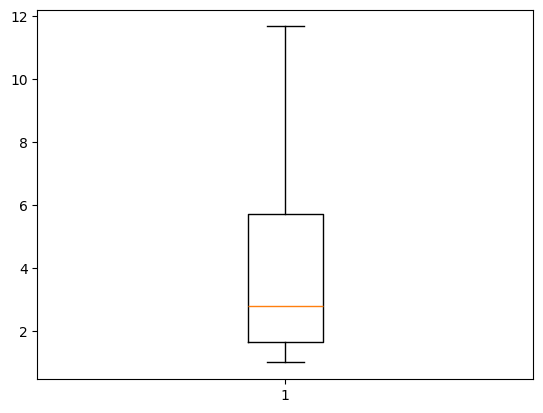

In [136]:
plt.boxplot(df_main[df_main['yield_fact'] > 1]['yield_fact'], showfliers=False)

### ТМЦ и CЗР

In [137]:
df_main['кг_fert'].max()

np.float64(22969875109.48)

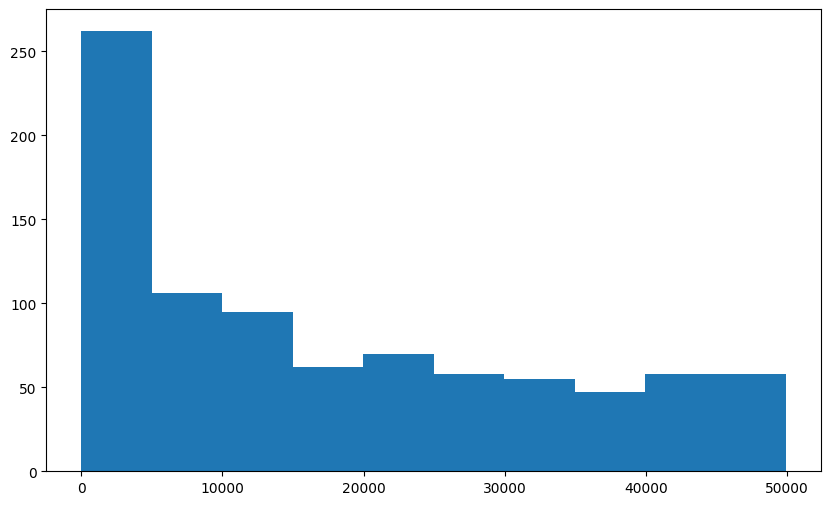

In [138]:
plt.figure(figsize=(10, 6))

# plt.yscale('log')

plt.hist(df_main.query('кг_fert > 0. and кг_fert < 50000')['кг_fert'])

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x71069c717f70>,
 'caps': [<matplotlib.lines.Line2D at 0x71069c715240>,
 'boxes': [<matplotlib.lines.Line2D at 0x71069c716860>],
 'medians': [<matplotlib.lines.Line2D at 0x71069c717eb0>],
 'fliers': [],
 'means': []}

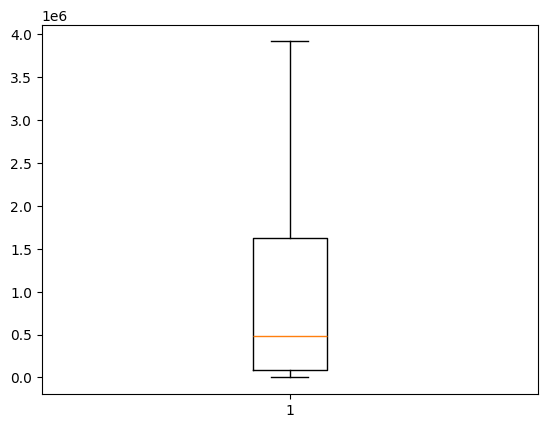

In [139]:
plt.boxplot(df_main.query('кг_fert > 0')['кг_fert'], showfliers=False)

## Чистка

In [140]:
df_main.head()

,season,field,p2o5,k2o,humus,ph,crop,region,yield_plan,yield_fact,кг_fert,л_fert,кг_pp,л_pp,fact_plan_diff
0,2023,22.47.01.001.01,221.05,206.3,4.05,5.25,Оз.пшеница мягкая,Алтай,3.8,190.592405,4457166.035,0.0,13.94,127.390,186.792405
1,2023,22.47.01.003.00,186.50,174.8,5.90,5.40,Оз.пшеница мягкая,Алтай,3.8,1.851617,8226128.065,0.0,20.58,182.256,-1.948383
2,2023,22.47.01.004.00,166.60,147.9,5.60,5.40,Оз.пшеница мягкая,Алтай,3.8,1.418186,4386226.595,0.0,12.27,108.668,-2.381814
3,2023,22.47.01.006.02,194.70,195.9,4.00,5.15,Оз.пшеница мягкая,Алтай,3.8,2.187347,586686.335,0.0,2.89,26.346,-1.612653
4,2023,22.47.01.007.02,184.20,171.4,4.40,5.05,Оз.пшеница мягкая,Алтай,3.8,2.109071,1013707.990,0.0,3.89,35.592,-1.690929


In [141]:
def remove_outliers_iqr(df, columns, k=1.5):
    cleared = df.copy()
    to_drop = []

    for column in columns:
        Q1 = cleared[column].quantile(0.25)
        Q3 = cleared[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR

        # Найти индексы выбросов для текущего столбца
        outliers = cleared[(cleared[column] < lower_bound) | (cleared[column] > upper_bound)].index
        to_drop.extend(outliers)

        # Удалить выбросы для текущего столбца
        cleared = cleared[(cleared[column] >= lower_bound) & (cleared[column] <= upper_bound)]

    # Создать DataFrame с выбросами
    to_drop = list(set(to_drop))  # Удалить дубликаты индексов
    outliers_df = df.loc[to_drop]

    return cleared, outliers_df


In [142]:
df_main_clear, df_main_trash = remove_outliers_iqr(df_main, ['yield_fact', 'p2o5', 'k2o'], 1.5)

In [143]:
1 - df_main_clear.shape[0] / df_main.shape[0]

0.11810486073184057

In [144]:
df_main_trash.describe()

,season,p2o5,k2o,humus,ph,yield_plan,yield_fact,кг_fert,л_fert,кг_pp,л_pp,fact_plan_diff
count,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,8.650000e+02,8.650000e+02,865.000000,865.000000,865.000000
mean,2023.456647,165.946520,164.006266,4.565572,5.429295,5.221329,1913.600992,2.916627e+07,5.839113e+04,17.321204,157.352470,1908.379662
std,0.498405,109.178462,103.436421,1.656501,0.620194,2.357648,3918.176432,7.810656e+08,1.460581e+06,50.074104,993.515486,3917.450600
min,2023.000000,11.000000,27.000000,0.800000,3.600000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,-8.431687
25%,2023.000000,84.000000,90.000000,3.400000,5.000000,3.400000,3.180000,4.347810e+03,0.000000e+00,0.000000,9.280000,-0.767835
50%,2023.000000,127.000000,127.000000,4.900000,5.300000,5.000000,143.832601,2.672105e+05,0.000000e+00,0.510000,44.996000,137.945845
75%,2024.000000,244.200000,216.880000,5.800000,5.700000,7.500000,2820.410000,1.390173e+06,0.000000e+00,8.660000,115.040000,2814.910000
max,2024.000000,679.000000,586.000000,9.500000,8.000000,11.000000,78114.350000,2.296988e+10,4.293744e+07,562.080000,19129.770000,78106.850000


In [145]:
df_main_clear.to_csv("../data/df_main_clear.csv")
df_main_trash.to_csv("../data/df_main_trash.csv")

## После чистки

### Хим

array([[<Axes: title={'center': 'p2o5'}>,
        <Axes: title={'center': 'k2o'}>],
       [<Axes: title={'center': 'humus'}>,
        <Axes: title={'center': 'ph'}>]], dtype=object)

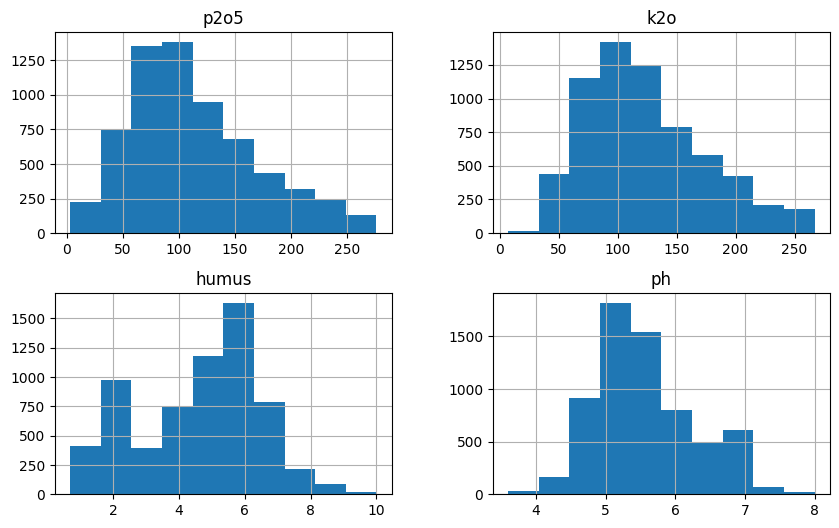

In [146]:
df_main_clear[['p2o5', 'k2o', 'humus', 'ph']].hist(figsize=(10, 6))

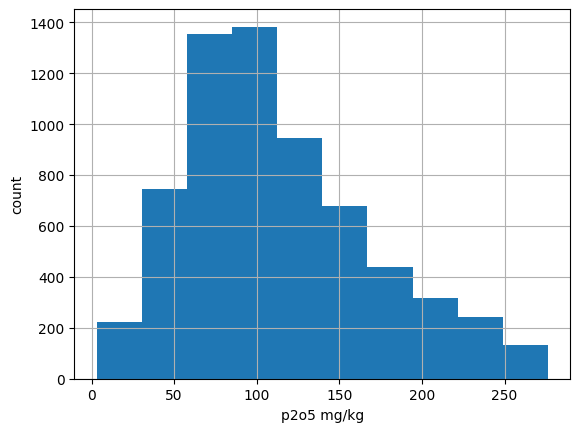

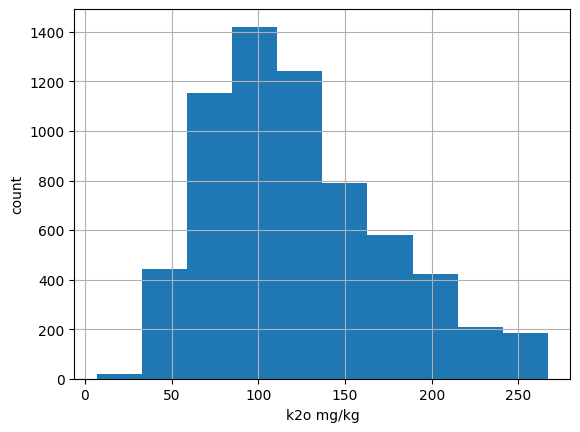

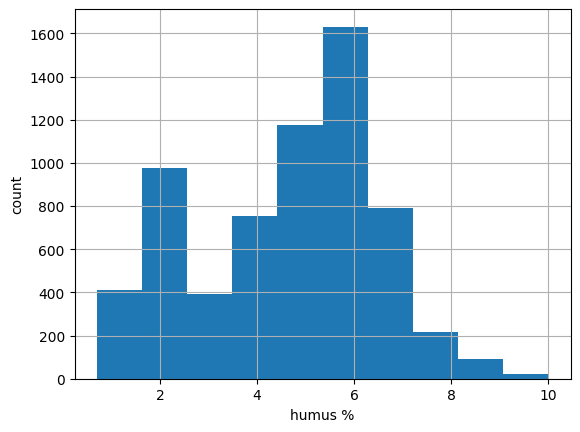

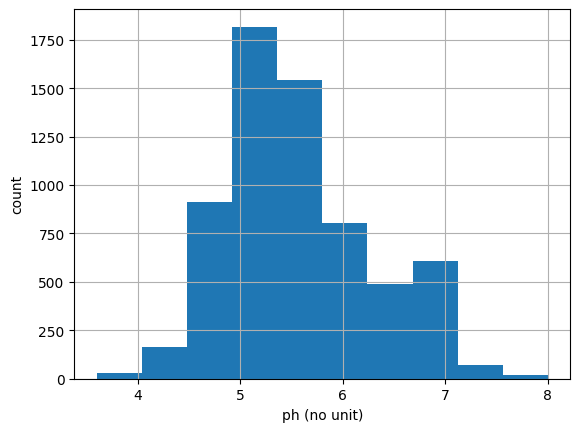

In [147]:
# p2o5
df_main_clear['p2o5'].hist()

plt.xlabel('p2o5 mg/kg')
plt.ylabel('count')

plt.show()

# k2o
df_main_clear['k2o'].hist()

plt.xlabel('k2o mg/kg')
plt.ylabel('count')

plt.show()

# humus
df_main_clear['humus'].hist()

plt.xlabel('humus %')
plt.ylabel('count')

plt.show()

# ph
df_main_clear['ph'].hist()

plt.xlabel('ph (no unit)')
plt.ylabel('count')

plt.show()


### Категориальные признаки

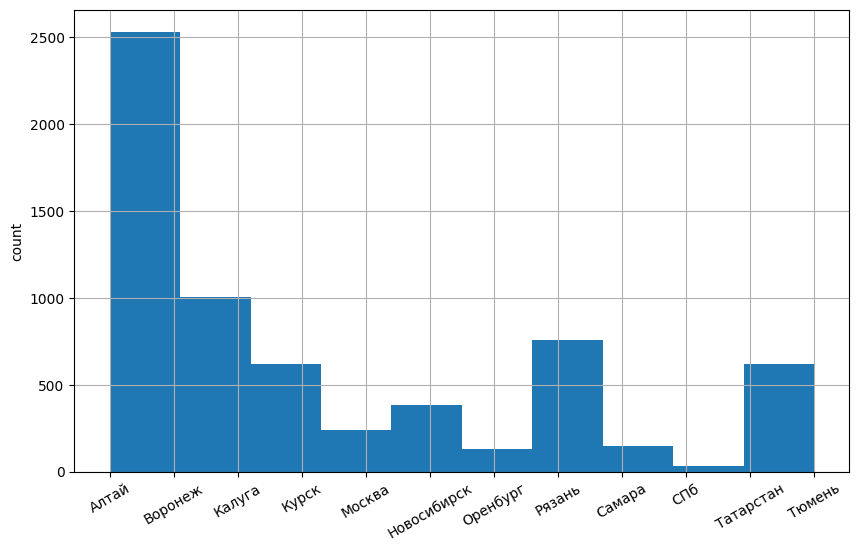

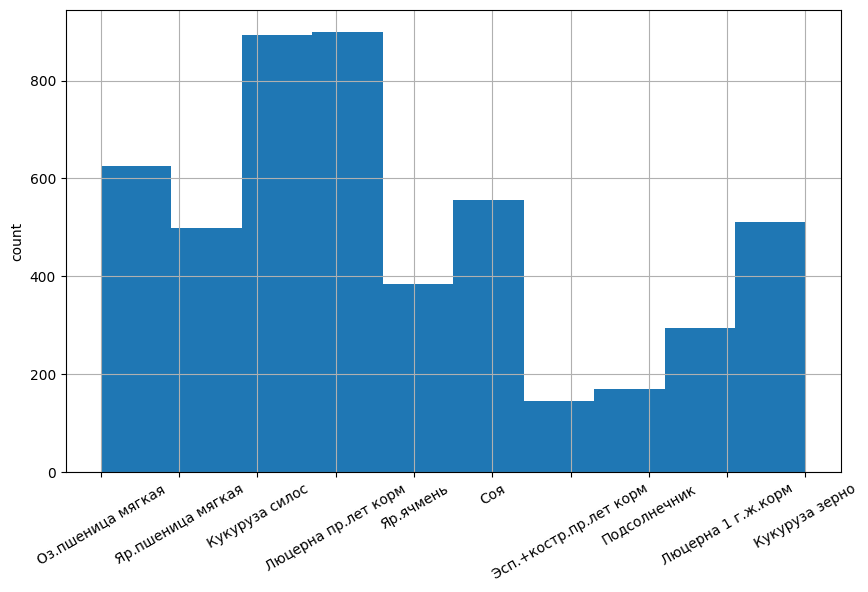

In [148]:
df_main_clear['region'].hist(figsize=(10, 6), xrot=30)

plt.ylabel('count')

plt.show()

df_main_clear.query(f"crop in {top_crops}")['crop'].hist(figsize=(10, 6), xrot=30)

plt.ylabel('count')

plt.show()

### Урожайности

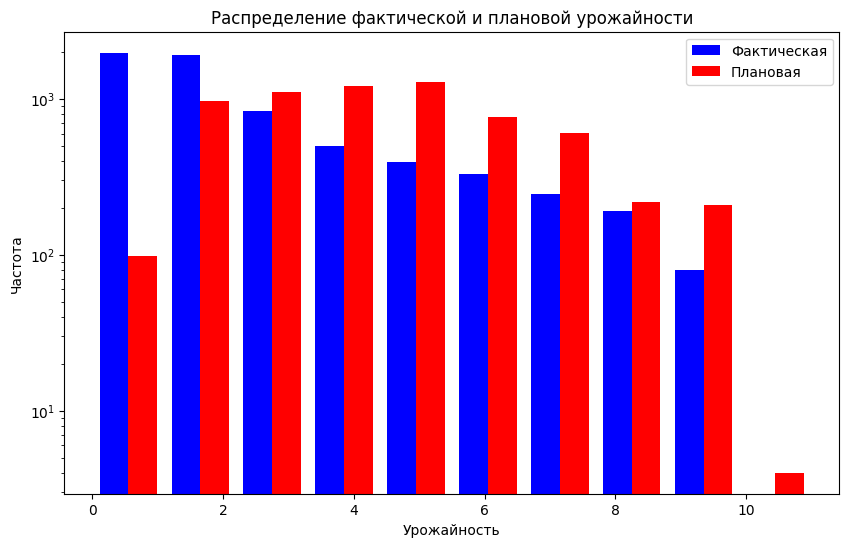

In [163]:
plt.figure(figsize=(10, 6))

plt.hist([df_main_clear['yield_fact'], df_main_clear['yield_plan']], color=['blue', 'red'], label=['Фактическая', 'Плановая'])

plt.yscale('log')

plt.title("Распределение фактической и плановой урожайности")
plt.ylabel("Частота")
plt.xlabel("Урожайность")

plt.legend()

plt.show()

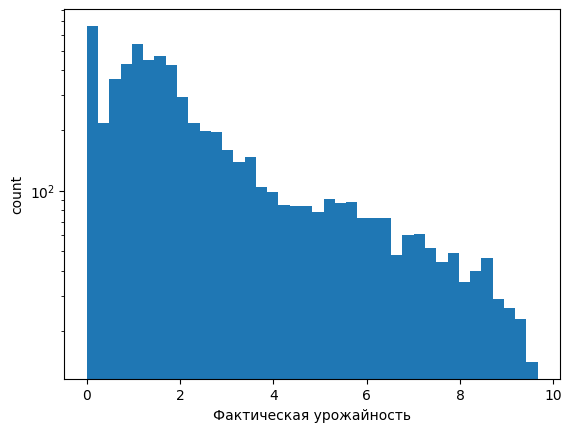

In [150]:
plt.hist(df_main_clear['yield_fact'], bins=40)

plt.yscale('log')

plt.xlabel('Фактическая урожайность')
plt.ylabel('count')

plt.show()

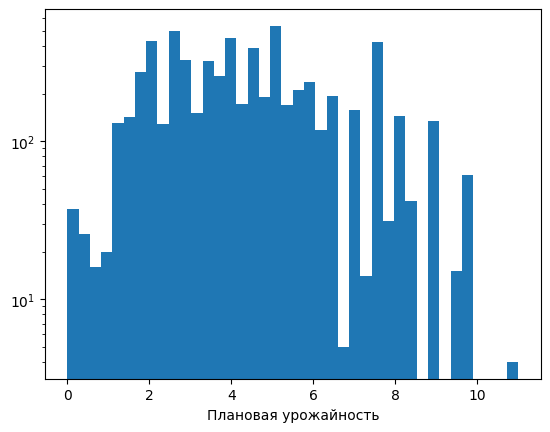

In [151]:
plt.hist(df_main_clear['yield_plan'], bins=40)

plt.yscale('log')

plt.xlabel('Плановая урожайность')

plt.show()

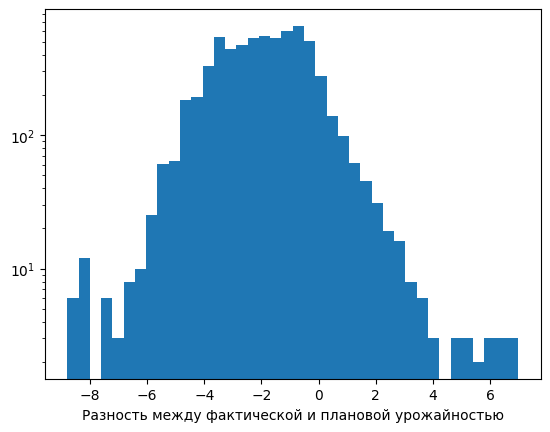

In [152]:
plt.hist(df_main_clear['fact_plan_diff'], bins=40)

plt.yscale('log')

plt.xlabel('Разность между фактической и плановой урожайностью')

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x71069ba24790>,
 'caps': [<matplotlib.lines.Line2D at 0x71069ba26920>,
 'boxes': [<matplotlib.lines.Line2D at 0x71069ba25e40>],
 'medians': [<matplotlib.lines.Line2D at 0x71069ba252a0>],
 'fliers': [],
 'means': []}

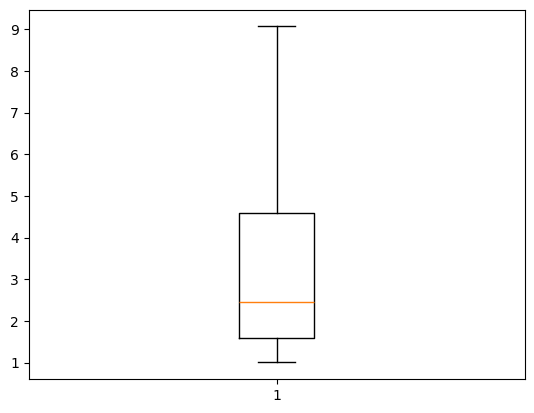

In [153]:
plt.boxplot(df_main_clear[df_main_clear['yield_fact'] > 1]['yield_fact'], showfliers=False)

### ТМЦ и CЗР

In [154]:
df_main_clear['кг_fert'].max()

np.float64(1405217278.8)

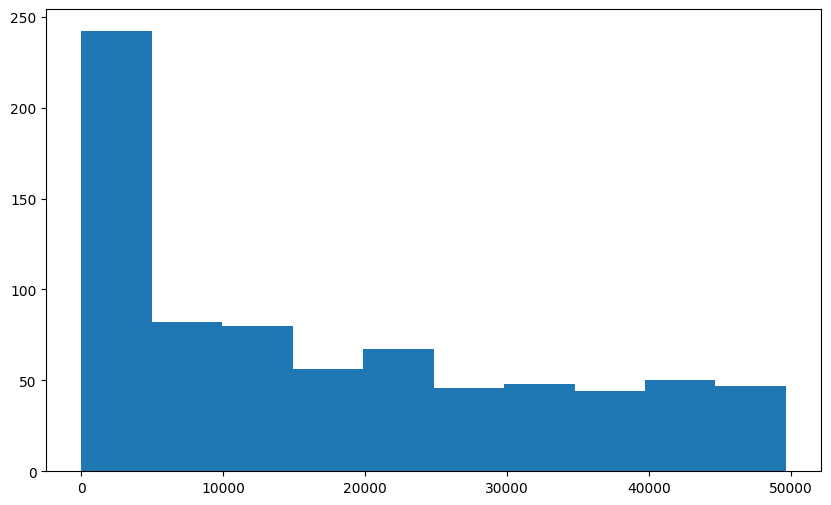

In [165]:
plt.figure(figsize=(10, 6))

# plt.yscale('log')

plt.hist(df_main_clear.query('кг_fert > 0. and кг_fert < 50000')['кг_fert'])

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x71069d171270>,
 'caps': [<matplotlib.lines.Line2D at 0x71069d1717b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x71069d170fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x71069d329270>],
 'fliers': [],
 'means': []}

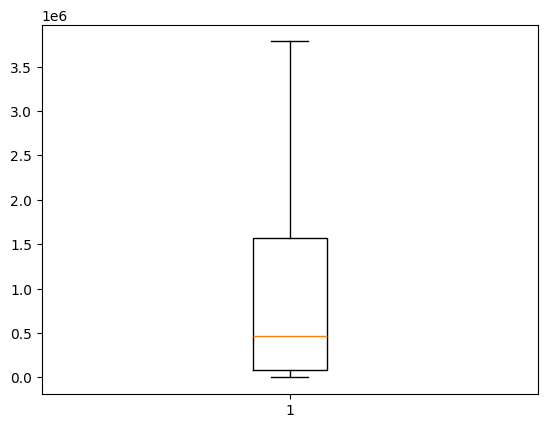

In [ ]:
plt.boxplot(df_main_clear.query('кг_fert > 0')['кг_fert'], showfliers=True)